# ECE 110/210 - Brain-Inpired ML
# Final Presentation of ML model
### Written by Hunter Schweiger, Sebastian Hernandez, Daniel Solis

What you will learn: Cell type regional classification with a hybrid convolutional and fully-connected network (FCN) model using neuronal electrophysiology data

## 1. Imports

In [1]:
import pandas as pd 
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix
from tqdm import tqdm
import time
import os
from IPython.display import clear_output

## 2. Training a Hybrid Model
Let's train a hybrid model on the neuronal electrophysiology data. The reason we are using a hybrid model is that different features perform best when used with different architectures. For instance, static features calculated from waveforms such as mean firing rate or spike time tiling coefficient (STTC) are best fed into a FCN layer or other means of classification such as XgBoost. In contrast, the waveform is similar to image classification where we would want the model to focus on and pick out the most important elements of its shape which is why it is fed into convolutional layers. Here the model consists of 5 static features being fed into 3 FCN layers and 100 interpolated waveform points fed into 3 convolutional layers. The 2 paths converge and are fed into 2 more FCN layers before making the final classification. 

For this dataset we have 14,259 number of putative neuronal units taken from dorsal and ventral mouse forebrain stem cell derived tissue also known as organoids. 11,573 number of units from dorsal and 2,686 number of units from ventral. The reasoning behind this project was that these brain regions are similar in identity but have differing excitatory to inhibitory ratios of neurons. The goal is to use this model to predict whether the unit is from dorsal or ventral forebrain tissue.  

If there are lines of code you don't understand, then copy-paste them into ChatGPT and query what they do.

In [2]:
# Device detection with M1/M2 support
def get_device():
    if torch.backends.mps.is_available():
        return torch.device("mps")
    elif torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

In [3]:

class PredictModel(nn.Module):
    def __init__(self, input_size=105, hidden_size=64, output_size=1):
        super().__init__()
        
        # Static features pathway with residual connections
        self.static_block1 = nn.Sequential(
            nn.Linear(input_size-100, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        self.static_block2 = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        self.static_block3 = nn.Sequential(
            nn.Linear(hidden_size, hidden_size//2),
            nn.BatchNorm1d(hidden_size//2),
            nn.ReLU()
        )
        
        # Improved waveform pathway
        self.waveform_cnn = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.MaxPool1d(2),
            
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.MaxPool1d(2),
            
            nn.Conv1d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.MaxPool1d(2),
            
            nn.Flatten()
        )
        
        cnn_output_size = 64 * 12  # Adjusted for additional pooling
        
        self.waveform_fcn = nn.Sequential(
            nn.Linear(cnn_output_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size, hidden_size//2),
            nn.BatchNorm1d(hidden_size//2),
            nn.ReLU()
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_size//2),
            nn.BatchNorm1d(hidden_size//2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size//2, output_size),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        static_features = x[:, :5]
        waveform = x[:, 5:].unsqueeze(1)
        
        static_out1 = self.static_block1(static_features)
        static_out2 = self.static_block2(static_out1) + static_out1
        static_out = self.static_block3(static_out2)
        
        waveform_cnn = self.waveform_cnn(waveform)
        waveform_out = self.waveform_fcn(waveform_cnn)
        
        combined = torch.cat((static_out, waveform_out), dim=1)
        return self.classifier(combined)

## 3. Create the Training Plots
We need to create the plots for tracking how well our model is doing. The 4 plots will be "Training and Validation Loss", "Training and Validation Accuracy", "Learning Rate Schedule", and "Epoch Training Time"

We will go more in depth into what each plot is showing after we run the model

In [4]:
class ImprovedTrainingManager:
    def __init__(self, model, criterion, optimizer, scheduler=None):
        self.device = get_device()
        print(f"Using device: {self.device}")
        
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.model.to(self.device)
        
        self.history = {
            'train_loss': [],
            'val_loss': [],
            'train_acc': [],
            'val_acc': [],
            'epoch_times': [],
            'learning_rates': []
        }
        
        self.smoothing = 0.1
        
    def plot_training_progress(self):
        """Create an interactive visualization of training progress."""
        clear_output(wait=True)
        
        fig = plt.figure(figsize=(15, 10))
        
        # Plot 1: Loss
        ax1 = plt.subplot(2, 2, 1)
        ax1.plot(self.history['train_loss'], label='Train Loss', color='blue')
        ax1.plot(self.history['val_loss'], label='Val Loss', color='red')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_title('Training and Validation Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Plot 2: Accuracy
        ax2 = plt.subplot(2, 2, 2)
        ax2.plot(self.history['train_acc'], label='Train Acc', color='blue')
        ax2.plot(self.history['val_acc'], label='Val Acc', color='red')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.set_title('Training and Validation Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        # Plot 3: Learning Rate
        ax3 = plt.subplot(2, 2, 3)
        ax3.plot(self.history['learning_rates'], color='green')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Learning Rate')
        ax3.set_title('Learning Rate Schedule')
        ax3.grid(True)
        ax3.set_yscale('log')
        
        # Plot 4: Epoch Time
        ax4 = plt.subplot(2, 2, 4)
        ax4.plot(self.history['epoch_times'], color='purple')
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('Time (seconds)')
        ax4.set_title('Epoch Training Time')
        ax4.grid(True)
        
        plt.tight_layout()
        plt.show()

    def criterion_with_smoothing(self, outputs, targets):
        smooth_targets = targets * (1 - self.smoothing) + 0.5 * self.smoothing
        return self.criterion(outputs, smooth_targets)
    
    def train_epoch(self, train_loader, accumulation_steps):
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        self.optimizer.zero_grad()
        
        progress_bar = tqdm(train_loader, desc='Training', leave=False)
        for i, (batch_X, batch_y) in enumerate(progress_bar):
            batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)
            
            outputs = self.model(batch_X)
            loss = self.criterion_with_smoothing(outputs, batch_y)
            
            loss = loss / accumulation_steps
            loss.backward()
            
            if (i + 1) % accumulation_steps == 0:
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                self.optimizer.step()
                self.optimizer.zero_grad()
            
            total_loss += loss.item() * accumulation_steps
            predicted = (outputs > 0.5).float()
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
            
            progress_bar.set_postfix({
                'loss': f'{loss.item() * accumulation_steps:.4f}',
                'acc': f'{(correct/total)*100:.2f}%'
            })
        
        return total_loss / len(train_loader), correct / total

    def validate(self, val_loader):
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)
                outputs = self.model(batch_X)
                loss = self.criterion_with_smoothing(outputs, batch_y)
                
                total_loss += loss.item()
                predicted = (outputs > 0.5).float()
                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()
        
        return total_loss / len(val_loader), correct / total

    def train(self, train_loader, val_loader, epochs=100, early_stopping_patience=10, accumulation_steps=4):
        best_val_loss = float('inf')
        patience_counter = 0
        
        for epoch in range(epochs):
            epoch_start_time = time.time()
            
            # Training phase
            train_loss, train_acc = self.train_epoch(train_loader, accumulation_steps)
            
            # Validation phase
            val_loss, val_acc = self.validate(val_loader)
            
            # Record time and learning rate
            epoch_time = time.time() - epoch_start_time
            current_lr = self.optimizer.param_groups[0]['lr']
            
            # Update history
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_acc'].append(val_acc)
            self.history['epoch_times'].append(epoch_time)
            self.history['learning_rates'].append(current_lr)
            
            # Plot progress every 2 epochs
            if epoch % 2 == 0:
                self.plot_training_progress()
            
            print(f'\nEpoch [{epoch+1}/{epochs}]')
            print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%')
            print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%')
            print(f'Learning Rate: {current_lr:.6f}')
            print(f'Time: {epoch_time:.2f}s')
            
            # Early stopping check
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'val_loss': val_loss,
                    'val_acc': val_acc
                }, 'best_model.pth')
                print("✓ Saved new best model")
            else:
                patience_counter += 1
                print(f"! Validation loss didn't improve for {patience_counter} epochs")
            
            # Learning rate scheduling
            if self.scheduler is not None:
                if isinstance(self.scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                    self.scheduler.step(val_loss)
                else:
                    self.scheduler.step()
            
            # Early stopping
            if patience_counter >= early_stopping_patience:
                print(f'\nEarly stopping triggered after epoch {epoch+1}')
                break
        
        # Load best model
        checkpoint = torch.load('best_model.pth')
        self.model.load_state_dict(checkpoint['model_state_dict'])
        print(f"\nTraining completed. Best validation loss: {checkpoint['val_loss']:.4f}")
        print(f"Best validation accuracy: {checkpoint['val_acc']*100:.2f}%")
        
        # Final plot
        self.plot_training_progress()
        
        return self.history

In [5]:

def train_model(X_train, y_train, X_test, y_test, save_path="save_plots", batch_size=64):
    device = get_device()
    
    # Initialize improved model and training components
    model = PredictModel()
    criterion = nn.BCELoss()
    optimizer = optim.AdamW(
        model.parameters(),
        lr=0.0005,
        weight_decay=0.01
    )
    
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer,
        T_0=10,
        T_mult=2,
        eta_min=1e-6
    )
    
    # Prepare data with larger batch size
    train_size = int(0.8 * len(X_train))
    train_dataset = TensorDataset(X_train[:train_size], y_train[:train_size])
    val_dataset = TensorDataset(X_train[train_size:], y_train[train_size:])
    
    # For M1/M2 Macs, we'll adjust num_workers based on system
    import platform
    if platform.processor() == 'arm':
        num_workers = 0  # M1/M2 Macs sometimes work better with 0 workers
    else:
        num_workers = 4
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True if device != "cpu" else False
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True if device != "cpu" else False
    )
    
    trainer = ImprovedTrainingManager(model, criterion, optimizer, scheduler)
    
    # Add gradient accumulation for larger effective batch size
    accumulation_steps = 4
    effective_batch_size = batch_size * accumulation_steps
    
    print(f"Training with effective batch size: {effective_batch_size}")
    
    return trainer.train(
        train_loader,
        val_loader,
        epochs=100,
        early_stopping_patience=10,
        accumulation_steps=accumulation_steps
    )

## 4. Run the Model
Let's run the model and see how well we do

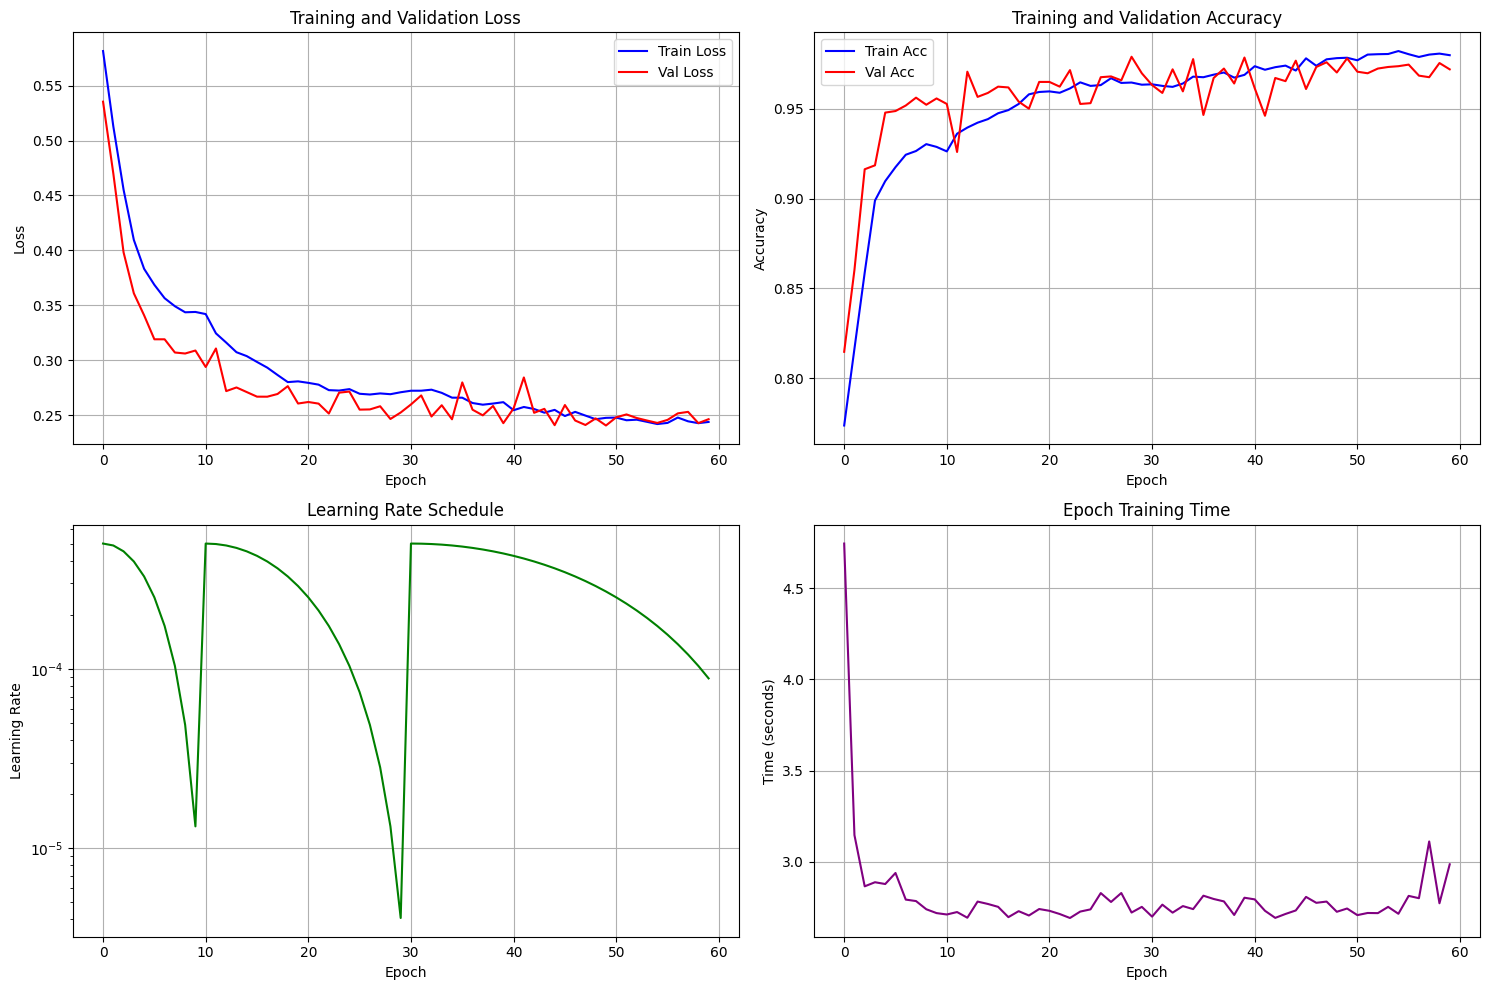

In [ ]:
device = get_device()
print(f"Using device: {device}")

# Load and prepare data
train_data = pd.read_csv('./training_data.csv')
test_data = pd.read_csv('./test_data.csv')

X_train = torch.FloatTensor(train_data.drop('label', axis=1).values)
y_train = torch.FloatTensor(train_data['label'].values).reshape(-1, 1)
X_test = torch.FloatTensor(test_data.drop('label', axis=1).values)
y_test = torch.FloatTensor(test_data['label'].values).reshape(-1, 1)

# Train model with improvements
trainer = train_model(
    X_train, y_train,
    X_test, y_test,
    # save_path='./improved_training_plots/',
    batch_size=64
)

## 5. Analyzing the Model
How did it do? Use the explanations below to evaluate how the model did.

1. Training and Validation Loss: This plot shows the training loss (blue) and validation loss (red). Training loss is a measurement of how well the model is fitting to the training data while validation loss is the error when fitting to unseen data. Should see them both drasticly be reduced and converge!

2. Traing and Validation Accuracy: This plot shows how accurate the model is on the training and validation accuracy. Should be inversely correlated with loss.

3. Learning Rate Schedule: This plot shows the learning rate of the model. The reason for the jumps is a "restart" initialized by "CosineAnnealingWarmRestarts". What this does is help to escape local minima by restarting the learning rate except we are keeping the model's learned parameters. In short, this helps to get around stalls in learning from suboptimal solutions.

4. Epoch Training Time: This plot shows how long each epoch takes to train before entering the next monitoring efficiency.